<a href="https://colab.research.google.com/github/100jy/dacon_ts_forecasting/blob/main/Normalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchcontrib

  Created wheel for torchcontrib: filename=torchcontrib-0.0.2-cp36-none-any.whl size=7531 sha256=91ecaff43f884c7eefc65b0000fa29c9936768c37fe3ac396139bc02e6469c69
  Stored in directory: /root/.cache/pip/wheels/06/06/7b/a5f5920bbf4f12a2c927e438fac17d4cd9560f8336b00e9a99
Successfully built torchcontrib


# 전처리

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.utils.data import Dataset
import torch.optim.adam
from torchcontrib.optim import SWA
import datetime
import matplotlib.pyplot as plt 
from tqdm import tqdm
import torch.nn.functional as F
from torch.autograd import Variable

ModuleNotFoundError: ignored

In [ ]:

train = pd.read_csv("./drive/MyDrive/데이콘/train.csv", encoding = 'euc-kr')

# 시간 관련 변수들
date_time = pd.to_datetime(train.DateTime)
#일자
train['Date'] = date_time.dt.date
train = train.groupby(train['Date']).sum().reset_index()  


def log_trans(x):
  return np.log(1+x)

def minmax(x):
  return (x-x.min()) / (x.max()-x.min())


for target in ['사용자', '세션', '신규방문자', '페이지뷰']:
  train[target+'_mean'] = (train[target].rolling(60).mean())
  train[target+'_std'] = (train[target].rolling(60).std())
  

# 요일 혹은 분기정보
date_time = pd.to_datetime(train['Date'])
train['DayOfWeek'] = (date_time.dt.weekday)/6
train['DayOfMon'] = (date_time.dt.day)/31
train['Quarter'] = (date_time.dt.quarter)/4

train['Year'] = ((date_time.dt.year) -2019)
train['Days'] = ((date_time.max() - date_time).dt.days + 1)
train['Days'] /= train['Days'].max()

# 보간해줌
train.iloc[479,1:] = (train.iloc[477,1:] + train.iloc[480,1:]) // 2
train.iloc[478,1:] = (train.iloc[477,1:] + train.iloc[479,1:]) // 2

# ts feature 생성 
for target in ['사용자', '세션', '신규방문자', '페이지뷰']:
    train[f'{target}CumSum'] = train[target].cumsum()

    for k in [3,7,14,21]:
        train[f'{target}RollingMean{k}'] =  minmax(train[target].rolling(k).mean())

    train[f'{target}RollingStd21'] =  minmax(train[target].rolling(21).std().round(0))
    train[f'{target}DaysSince10000'] = (train[f'{target}CumSum'] > 10000) * 1
    train[f'{target}DaysSince100000'] = (train[f'{target}CumSum'] > 100000) * 1

    train[f'{target}RollingMeanDiff2w'] = train[f'{target}RollingMean7'] / (train[f'{target}RollingMean14'] + 1) - 1
    train[f'{target}RollingMeanDiff3w'] = train[f'{target}RollingMean7'] / (train[f'{target}RollingMean21'] + 1) - 1


    train[f'{target}CumSum'] = minmax(train[target].cumsum())
    
    #normalizing
    train[target] = (train[target] - train[target+'_mean']) / (train[target+'_std'] + 1e-5)
    train[target+'_mean'] = log_trans(train[target+'_mean'])
    train[target+'_std'] = log_trans(train[target+'_std'])
    

# 진행중인 대회수 변수 추가
comp = pd.read_csv("./drive/MyDrive/데이콘/info_competition.csv", encoding = 'euc-kr', index_col=0)
comp = comp.iloc[1:]
comp = comp[comp['participants'] >=  (comp['participants'].mean() / 3)]

# 일자만 남기기
comp['period_start'] = pd.to_datetime(comp['period_start']).dt.date
comp['period_end'] = pd.to_datetime(comp['period_end']).dt.date

train['OnGoingComp'] = [0 for x in range(len(train))]

for start, end in zip(comp['period_start'], comp['period_end']): 
  
  try:
    start_idx = train[start == train['Date']].index[0]
  except:
    start_idx = min(train.index)

  try:
    end_idx = train[end == train['Date']].index[0]
  except:
    end_idx = max(train.index)
  
  for day in range(start_idx, end_idx+1):
    train['OnGoingComp'][train.index == day] += 1

train['OnGoingComp'] = train['OnGoingComp'].rolling(30).mean()
train['OnGoingComp'] /= train['OnGoingComp'].max()
train = train.dropna()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
train

,Date,사용자,세션,신규방문자,페이지뷰,사용자_mean,사용자_std,세션_mean,세션_std,신규방문자_mean,신규방문자_std,페이지뷰_mean,페이지뷰_std,DayOfWeek,DayOfMon,Quarter,Year,Days,사용자CumSum,사용자RollingMean3,사용자RollingMean7,사용자RollingMean14,사용자RollingMean21,사용자RollingStd21,사용자DaysSince10000,사용자DaysSince100000,사용자RollingMeanDiff2w,사용자RollingMeanDiff3w,세션CumSum,세션RollingMean3,세션RollingMean7,세션RollingMean14,세션RollingMean21,세션RollingStd21,세션DaysSince10000,세션DaysSince100000,세션RollingMeanDiff2w,세션RollingMeanDiff3w,신규방문자CumSum,신규방문자RollingMean3,신규방문자RollingMean7,신규방문자RollingMean14,신규방문자RollingMean21,신규방문자RollingStd21,신규방문자DaysSince10000,신규방문자DaysSince100000,신규방문자RollingMeanDiff2w,신규방문자RollingMeanDiff3w,페이지뷰CumSum,페이지뷰RollingMean3,페이지뷰RollingMean7,페이지뷰RollingMean14,페이지뷰RollingMean21,페이지뷰RollingStd21,페이지뷰DaysSince10000,페이지뷰DaysSince100000,페이지뷰RollingMeanDiff2w,페이지뷰RollingMeanDiff3w,OnGoingComp
59,2018-11-07,-0.556295,-0.584247,-0.384991,-0.432610,5.160300,4.607746,5.132066,4.561907,3.878811,3.885817,7.059603,6.741687,0.333333,0.225806,1.0,-1,0.925505,0.011630,0.012502,0.008066,0.007732,0.011912,0.015166,1,0,-0.991996,-0.992029,0.011399,0.012460,0.009208,0.009569,0.014604,0.017874,1,0,-0.990880,-0.990925,0.013005,0.010808,0.000299,0.000000,0.017190,0.052174,0,0,-0.999701,-0.999706,0.003535,0.006263,0.004785,0.004802,0.004843,0.002886,1,0,-0.995238,-0.995238,0.64375
60,2018-11-08,-0.383759,-0.352675,0.001401,-0.468571,5.146040,4.598840,5.118892,4.553833,3.869811,3.883374,7.044077,6.738265,0.500000,0.258065,1.0,-1,0.924242,0.011783,0.013054,0.008847,0.007626,0.009942,0.007583,1,0,-0.991220,-0.991240,0.011553,0.013300,0.009776,0.009289,0.012621,0.011289,1,0,-0.990314,-0.990346,0.013226,0.016469,0.004030,0.000877,0.012813,0.034783,0,0,-0.995973,-0.996021,0.003574,0.005307,0.004788,0.004814,0.004468,0.002483,1,0,-0.995235,-0.995233,0.64375
61,2018-11-09,-0.374020,-0.355272,-0.162480,-0.229845,5.133148,4.592309,5.107258,4.548561,3.865630,3.883535,7.027093,6.727741,0.666667,0.290323,1.0,-1,0.922980,0.011935,0.011673,0.009330,0.007394,0.008745,0.003791,1,0,-0.990738,-0.990751,0.011705,0.011900,0.010041,0.008838,0.011405,0.009407,1,0,-0.990047,-0.990072,0.013409,0.017499,0.007016,0.001315,0.010212,0.028986,0,0,-0.992993,-0.993055,0.003622,0.004020,0.004887,0.004915,0.004314,0.002297,1,0,-0.995137,-0.995134,0.64375
62,2018-11-10,-0.348252,-0.372892,0.277985,-0.154622,5.113593,4.569798,5.088625,4.528572,3.866328,3.883715,7.011935,6.718447,0.833333,0.322581,1.0,-1,0.921717,0.012087,0.012640,0.011672,0.008662,0.008177,0.003791,1,0,-0.988428,-0.988423,0.011852,0.012880,0.012163,0.010042,0.010781,0.008467,1,0,-0.987958,-0.987966,0.013691,0.025476,0.013435,0.004996,0.009451,0.028986,0,0,-0.986632,-0.986691,0.003673,0.004501,0.005812,0.005445,0.004424,0.002266,1,0,-0.994220,-0.994214,0.64375
63,2018-11-11,-0.219710,-0.251182,0.190051,0.441710,5.097628,4.552946,5.072984,4.512766,3.870159,3.884008,6.994514,6.691493,1.000000,0.354839,1.0,-1,0.920455,0.012250,0.013262,0.013456,0.009802,0.007862,0.002844,1,0,-0.986674,-0.986649,0.012010,0.013090,0.013641,0.011074,0.010333,0.007526,1,0,-0.986508,-0.986498,0.013954,0.027792,0.020152,0.008239,0.009578,0.028986,0,0,-0.980012,-0.980039,0.003748,0.006315,0.006863,0.006190,0.004481,0.002483,1,0,-0.993179,-0.993167,0.64375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,2020-11-04,2.359355,2.389423,2.271748,2.233255,7.821449,6.755353,7.803183,6.743263,6.387665,5.584357,10.959621,10.114925,0.333333,0.129032,1.0,1,0.006313,0.985299,1.000000,0.941008,0.910764,0.923425,0.981043,1,1,-0.507523,-0.510764,0.985572,1.000000,0.948846,0.913622,0.925348,0.961430,1,1,-0.504162,-0.507182,0.986276,1.000000,0.938050,0.926725,0.943165,0.863768,1,1,-0.513137,-0.517256,0.984458,1.000000,0.997799,0.912717,0.856685,0.996338,1,1,-0.478335,-0.462591,0.97500
788,2020-11-05,1.845771,1.789555,1.62

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54168 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48624 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54168 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_te

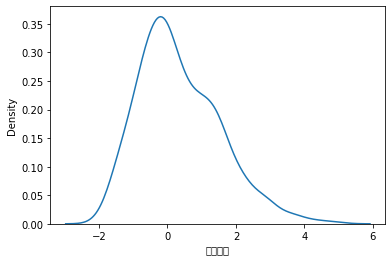

In [ ]:
import seaborn as sns
sns.kdeplot(train['페이지뷰'])

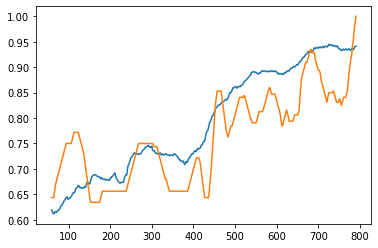

In [ ]:
(train['사용자_mean']*0.12).plot()
train['OnGoingComp'].plot()

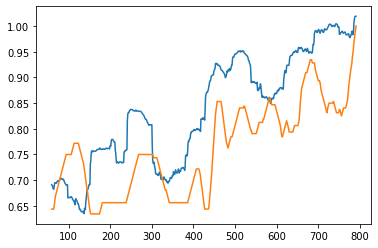

In [ ]:
(train['사용자_std']*0.15).plot()
train['OnGoingComp'].plot()

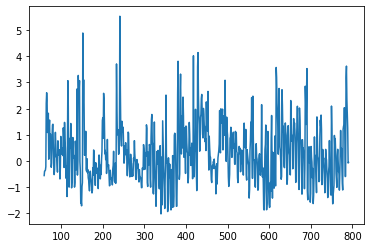

In [ ]:
train['사용자'].plot()

In [ ]:
def make_data(df, window_size=30):
  # in 180
  input_window = window_size
  # out 61 
  output_window = 61

  window_x = np.zeros((df.shape[0] - (input_window + output_window), input_window, df.shape[1]-1))
  window_y = np.zeros((df.shape[0] - (input_window + output_window), output_window, 12))

  for start in range(df.shape[0] - (input_window + output_window)):
      end = start + input_window    
      window_x[start,:, :] = df.iloc[start : end, 1: ].values
      window_y[start,:, :] = df.iloc[end   : end + output_window, 1: 13].values


  return window_x, window_y

In [ ]:
class DatasetWindows(Dataset):
  def __init__(self, df, input_days):

    x, y = make_data(df, input_days)
    
    self.x = torch.tensor(x, dtype=torch.float32).cuda()
    self.y = torch.tensor(y, dtype=torch.float32).cuda()
  
  def __len__(self):
    return len(self.x)
    
  def __getitem__(self, idx):
    return self.x[idx,...], self.y[idx,...]

# 모델

In [ ]:
# in 61 out 61일
# B x 61 x 75
# embedding
# B x 61 x 4
class SimpleLinear(nn.Module):
    def __init__(self, input_days, embedded_dim, hidden_size, num_layers, batch_out_p):
        super(SimpleLinear, self).__init__()

        self.embedding = nn.Sequential(nn.Linear(58, embedded_dim),
                                       nn.Dropout(batch_out_p),
                                       nn.ReLU())
        
        self.LSTM = nn.Sequential(nn.LSTM(input_size = input_days,
                            hidden_size = hidden_size,
                            num_layers=num_layers,
                            batch_first=True))
        
        self.LSTM_2 = nn.Sequential(nn.LSTM(input_size = hidden_size,
                            hidden_size = hidden_size,
                            num_layers=num_layers,
                            batch_first=True))
        
        
        self.last = nn.Sequential(nn.Linear(embedded_dim, 12))
    
    def forward(self, x_time):
        x_time = self.embedding(x_time)
        x_time = x_time.transpose(-2,-1)
        x_time,_ = self.LSTM(x_time)
        x_time,_ = self.LSTM_2(x_time)
        x_time = x_time[...,-61:]
        x_time = x_time.transpose(-2,-1)
        out_time = self.last(x_time)
        
        return out_time

In [ ]:
class ModelManager():
  def __init__(self, model_name, embedded_dim, hidden_size, num_layers, dropout_p, input_days, device='gpu'):
    super(ModelManager, self).__init__()

    self.input_days = input_days
    model =  model_name(input_days, embedded_dim, hidden_size, num_layers, dropout_p)
    if device == 'gpu':
      model =  model.cuda()
    self.model = model
    
  def fit(self, num_epochs=500, lr=1e-2 ,log=False, val_set=None, train_set=None):
    
    def get_val_loss():
      val_loss = self.make_val_plot(val_set, train_set, get_loss=True)
      return val_loss


    # Train model
    model = self.model
    dataset = DatasetWindows(train_set, self.input_days)
    dataloader = DataLoader(dataset, batch_size=30,  num_workers=0, pin_memory=False,
                                      shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    swa_scheduler = SWALR(optimizer, swa_lr=lr)
    swa_model = AveragedModel(model)
    self.model = swa_model
    criterion = nn.MSELoss(reduction='mean')
    running_loss = 0

    for epoch in range(num_epochs):
        for idx,data in enumerate(dataloader):
            x, y = data
            train_pred = model(x)
            loss = criterion(train_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if epoch % 100 == 99:
          swa_model.update_parameters(model)
          swa_scheduler.step()
          if log:
            if val_set.any().any():
              val_loss = get_val_loss()
              print(f"{epoch+1} Epochs train MSE: {running_loss/(100):1.5f}, ", f"{epoch+1} Epochs val MSE: {val_loss:1.5f}")
            else: 
              print(f"{epoch+1} Epochs train MSE: {loss.item():1.5f}")
            running_loss = 0

  @staticmethod
  def inverse_log(x):
    # 32bit 사용시 단위문제 발생..
    return np.exp(x)-1

  def predict(self, df):
    input_days = self.input_days
    last_observe = df.iloc[-input_days:,1:]
    inp_tensor = torch.tensor(last_observe.values, dtype=torch.float32).cuda()
    inp_tensor = inp_tensor.unsqueeze(0)
    # normalizing 추가
    model = self.model.eval()
    prediction = model(inp_tensor).cpu().detach().squeeze().numpy()
    mu = self.inverse_log(prediction[:,[4,6,8,10]])
    sigma = self.inverse_log(prediction[:,[5,7,9,11]])
    x = prediction[:,:4]
    
    prediction = ((x * sigma) + mu)

    self.model = model.train()

    return  prediction.astype(np.int64)

  def make_val_plot(self, val_df, train_df, get_loss=False):
    #predict
    pred = self.predict(train_df)
    label = val_df

    def dacon_rmse(true, pred):  
      w0 = 1095.214646
      w1 = 1086.728535
      w2 = 268.070707
      w3 = 24236.194444

      score = (np.sqrt(np.mean(np.square(true[:,0] - pred[:,0]))) / w0 + 
               np.sqrt(np.mean(np.square(true[:,1] - pred[:,1]))) / w1 + 
               np.sqrt(np.mean(np.square(true[:,2] - pred[:,2]))) / w2 + 
               np.sqrt(np.mean(np.square(true[:,3] - pred[:,3]))) / w3  )
      return score

    if get_loss:
      return dacon_rmse(label.values, pred)

    for idx, key in enumerate(val_df.columns):
      plt.plot(figsize=(20,10))
      plt.plot(label.index,pred[:,idx])
      plt.plot(label[key])
      plt.legend(['predict', 'label'])
      plt.show()
      
    loss = dacon_rmse(label.iloc[:,:4].values, pred)
    print('RMSE : ' + str(loss))

In [ ]:
# train val split
train_whole = train
train_split = train[:-61]

val = train.iloc[-61:, 1:5]
mu = (np.exp(train.iloc[-61:, [5,7,9,11]])-1).values
sigma = (np.exp(train.iloc[-61:, [6,8,10,12]])-1).values
val.iloc[:,:] = ((val.values * sigma) + mu).astype(np.int64)

input_days = 90
embedded_dim = 256
hidden_size = 256
num_layers = 1
dropout_p = 0.5

simple = ModelManager(SimpleLinear, embedded_dim, hidden_size, num_layers, dropout_p, input_days)
simple.fit(num_epochs=10000, lr=1e-3, log=True, val_set=val, train_set=train_split)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


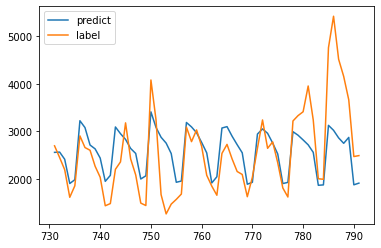

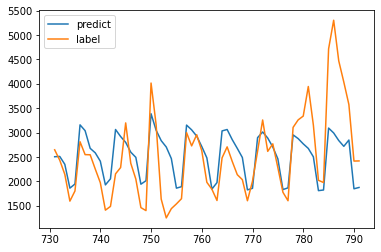

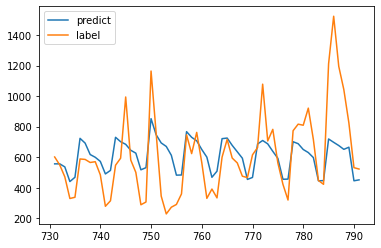

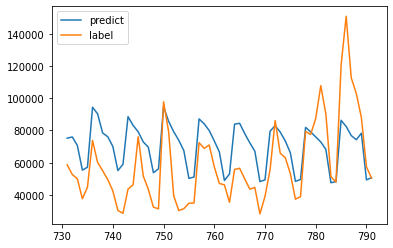

RMSE : 3.027368851243426


In [ ]:
simple.make_val_plot(val, train_split)

In [ ]:
embedded_dim = 256
hidden_size = 256
num_layers = 1
dropout_p = 0.3

predictor = ModelManager(SimpleLinear, embedded_dim, hidden_size, num_layers, dropout_p, train_whole, cv=1)
predictor.fit(num_epochs=300, lr=1e-3, log=False)

In [ ]:
predictor.make_val_plot(val, train_whole)

      DateTime   사용자    세션  신규방문자   페이지뷰
0   2020-11-09  3458  3364    901  90718
1   2020-11-10  3360  3253    806  96798
2   2020-11-11  3212  3134    775  90786
3   2020-11-12  3479  3390    897  94480
4   2020-11-13  3411  3343    879  93611
..         ...   ...   ...    ...    ...
56  2021-01-04  3638  3517    909  88828
57  2021-01-05  3701  3607    925  89306
58  2021-01-06  3003  2907    718  77136
59  2021-01-07  3377  3244    812  85296
60  2021-01-08  2644  2534    617  66927

[61 rows x 5 columns]
saved result


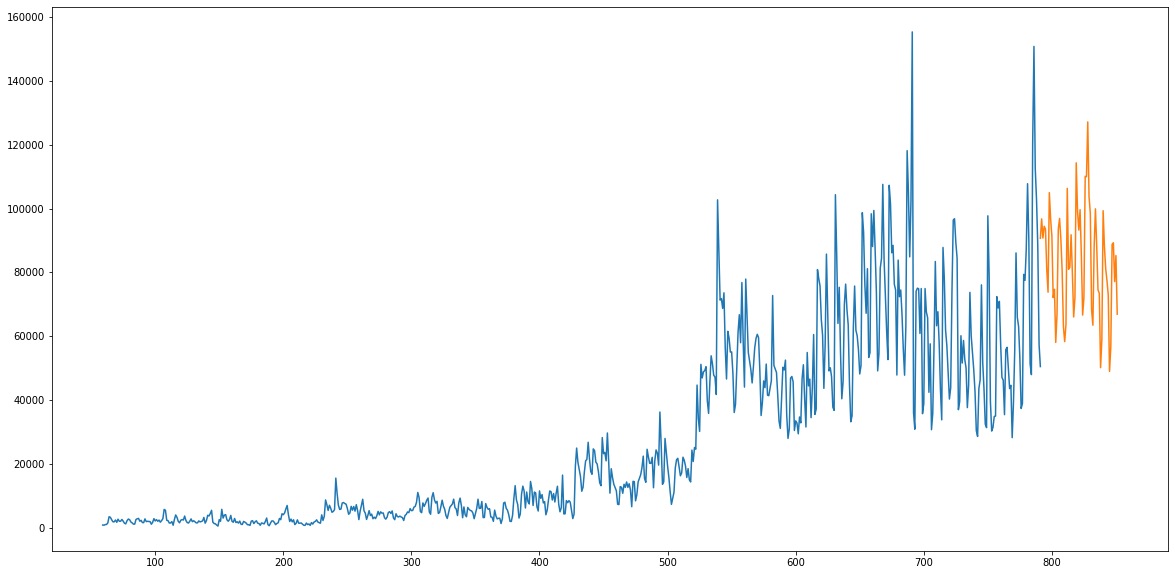

In [ ]:
submission = pd.read_csv("./drive/MyDrive/데이콘/submission.csv", encoding = 'euc-kr') 
submission.iloc[:,1:] = simple.predict(train_whole)
submission.to_csv('submission.csv', index = False, encoding = 'euc-kr')
print(submission)
print('saved result')

submission.columns = ['Date',   '사용자' ,   '세션',  '신규방문자',   '페이지뷰']

def inverse_log(x):
  # 32bit 사용시 단위문제 발생..
  return (np.exp(x)-1).astype(np.int64)

original = train.iloc[:,:5]
mu = (np.exp(train.iloc[:, [5,7,9,11]])-1).values
sigma = (np.exp(train.iloc[:, [6,8,10,12]])-1).values
original.iloc[:,1:] = ((original.iloc[:,1:].values * sigma) + mu).astype(np.int64)
submission.index = [x for x in range(max(original.index), max(original.index)+61)]

plt.figure(figsize=(20,10))
original['페이지뷰'].plot()
submission['페이지뷰'].plot()


#epoch=200, embedded_dim = 512, hidden_size = 512, 
#num_layers = 1, dropout_p = 0.5, input_days = 90
# score : 3.1472559986

In [ ]:
simple.fit(num_epochs=300, lr=1e-3, log=False)

      DateTime   사용자    세션  신규방문자   페이지뷰
0   2020-11-09  2925  2894    723  83471
1   2020-11-10  2639  2626    635  74984
2   2020-11-11  2412  2398    544  67119
3   2020-11-12  2366  2350    567  66525
4   2020-11-13  2044  2035    456  56910
..         ...   ...   ...    ...    ...
56  2021-01-04  2537  2507    616  65925
57  2021-01-05  2661  2634    684  70787
58  2021-01-06  2682  2651    659  69387
59  2021-01-07  2596  2554    675  65546
60  2021-01-08  2547  2488    586  68642

[61 rows x 5 columns]
saved result


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


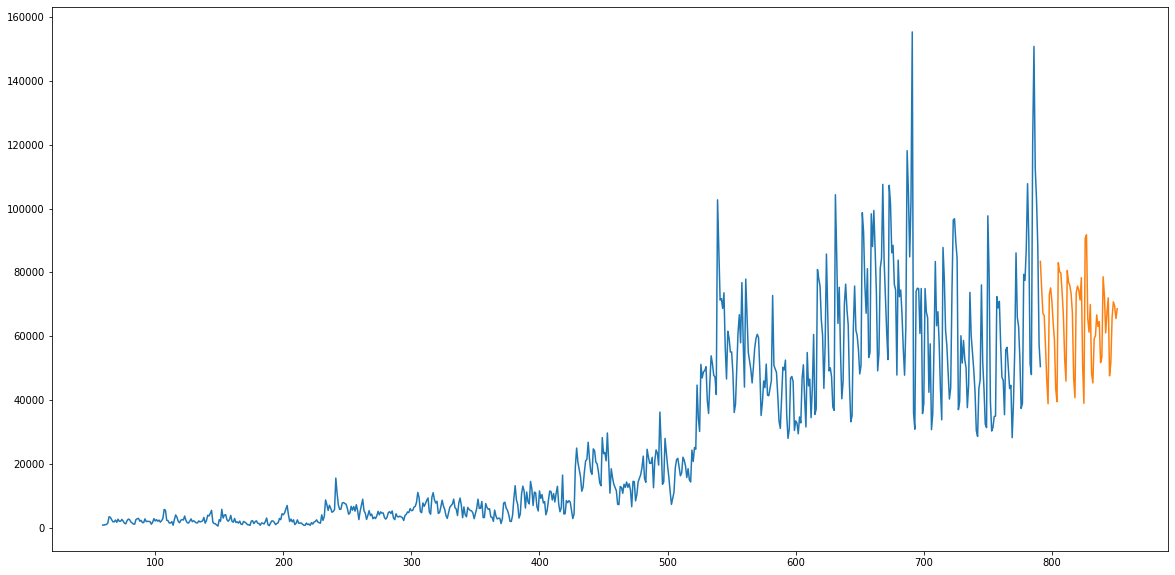

In [ ]:
submission = pd.read_csv("./drive/MyDrive/데이콘/submission.csv", encoding = 'euc-kr') 
submission.iloc[:,1:] = simple.predict(train_whole)
submission.to_csv('submission.csv', index = False, encoding = 'euc-kr')
print(submission)
print('saved result')

submission.columns = ['Date',   '사용자' ,   '세션',  '신규방문자',   '페이지뷰']

def inverse_log(x):
  # 32bit 사용시 단위문제 발생..
  return (np.exp(x)-1).astype(np.int64)

original = train.iloc[:,:5]
mu = (np.exp(train.iloc[:, [5,7,9,11]])-1).values
sigma = (np.exp(train.iloc[:, [6,8,10,12]])-1).values
original.iloc[:,1:] = ((original.iloc[:,1:].values * sigma) + mu).astype(np.int64)
submission.index = [x for x in range(max(original.index), max(original.index)+61)]

plt.figure(figsize=(20,10))
original['페이지뷰'].plot()
submission['페이지뷰'].plot()